# Machine Learning for Wind Farm Clustering
## 1. Setting Up the Design Matrix

In [1]:
%matplotlib inline
import csv
import sys
import os
import re
import numpy as np
import scipy as sp
import sklearn
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import SpectralClustering
import sklearn.metrics as metrics
import matplotlib
import matplotlib.pyplot as plt

/Users/zhjin/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
def preprocess(path = "./wind_capacity_factors_months_2_5_8.csv"):
    """
    A helper method
    pre-procss the data
    returns a dictionary of wind_point_id -> features
    the first two features is lat and lon, and the rest is all the capacity factors
    """
    
    # attributes = ['hour', 'wind_point_id', 'avg(capacity_factor)', 'lon', 'month', 'year', 'lat', 'day']
    # Load the wind CSV file
    windFile = path
    input_train_file = csv.DictReader(open(windFile))
    
    wind_point_dictionary = {}

    # keep the latitude and longitude of each point for plotting purposes
    position = []

    for row in input_train_file:
        wind_point_id = row['wind_point_id']
        features = []
        # we've added this point previously, so we just append the feature:
        if wind_point_id in wind_point_dictionary:
            features = wind_point_dictionary[wind_point_id]
            features.append(float(row['avg(capacity_factor)']))
            pass
        # we've not seen this point before:
        else:
            features.append(float(row['lat']))
            features.append(float(row['lon']))
            position.append([float(row['lat']), float(row['lon'])])
            features.append(float(row['avg(capacity_factor)']))
        # update the dictionary
        wind_point_dictionary[wind_point_id] = features

    position = np.array(position)
    
    return (position, wind_point_dictionary)

def preprocess2(folder_name = "Easter_Cape_Cod_MA") :
    '''
    Folder contains many csv files. Each csv file contains capacity factors of a wind point.
    preprocess2 returns a list of position of each wind point and wind point dictionary whose key is a site id 
    and value is a list consisting of the position(lat, lon) and the averages of capacity factors of each hour. 
    '''
    wind_point_dictionary = {}
    positions = []
    match = r".+\.csv"
    for root, subdirs, files in os.walk("./" + folder_name):
        for filename in files:
            # To check if the file is in the format of csv or not
            if (re.match(match, filename) != None) :
                features = []
                file_path = os.path.join(root, filename)
                # Open each file, create a list of features of a wind_point and add it to wind_point_dictionary(dictionary)
                # Also, create a list named position and append it to positions(list)
                with open(file_path, 'r') as f:
                    f_contents = f.readlines()
                    position = []
                    for counter, line in enumerate(f_contents) :
                        if (counter == 0) :
                            # store wind point id to a variable (later, it will be a key for dictionary)
                            wind_point_id = float(line.strip().split(",")[-1])
                        elif (counter == 1) :
                            # store longitude to a variable (to append lat and lon in order)
                            lon = float(line.strip().split(",")[-1])
                        elif (counter == 2) :
                            # append lat to features
                            lat = float(line.strip().split(",")[-1])
                            features.append(lat)
                            position.append(lat)
                        elif (counter == 3) :
                            # append lon to features and position. skip 4th row since it's just the names of columns 
                            features.append(lon)
                            position.append(lon)
                            pass
                        elif ((counter - 4) % 12 == 0) :
                            # append the first "minute" of an hour 
                            features.append(float(line.strip().split(",")[-1]))
                        elif ((counter - 4) % 12 == 11) :
                            # add the last "minute" of an hour and divide it by 12 to find the average
                            features[-1] += float(line.strip().split(",")[-1])
                            features[-1] /= 12
                        else :
                            # add 2nd to 11th "minutes" of an hour
                            features[-1] += float(line.strip().split(",")[-1])
                    positions.append(position)
                    wind_point_dictionary[wind_point_id] = features
                    f.close()
    positions = np.array(positions)
    return (positions, wind_point_dictionary)


def load_design_matrix(f=preprocess2, folder="Easter_Cape_Cod_MA"):
    """
    call this method to load the entire data matrix
    """
    position, wind_point_dictionary = f(folder)
    # next step: build the design matrix
    matrix = None
    

    for key in wind_point_dictionary.keys() :
        features = np.copy(wind_point_dictionary[key]) 
        #features = featureEngineering(features)
    
        if matrix is None:
            matrix = np.array([features])
        else:
            matrix = np.append(matrix, [features], axis = 0)
    
    return (position, matrix)

def plot_design_matrix(position, design_matrix):
    plt.figure(figsize=(20,20))
    plt.legend(loc=2,fontsize = 'xx-large')

    plt.scatter(position[:,0], position[:,1], c='blue', s=75, alpha = 0.6, label = "true wind point")

    plt.grid(True)
    plt.legend(loc='upper right')
    plt.xlabel("latitude")
    plt.ylabel("longitude")

    plt.show()
        

In [3]:
eastern_position, eastern_design_matrix = load_design_matrix(folder="Easter_Cape_Cod_MA")
western_position, western_design_matrix = load_design_matrix(folder="Western_Cape_Cod_MA")

/Users/zhjin/anaconda/lib/python2.7/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


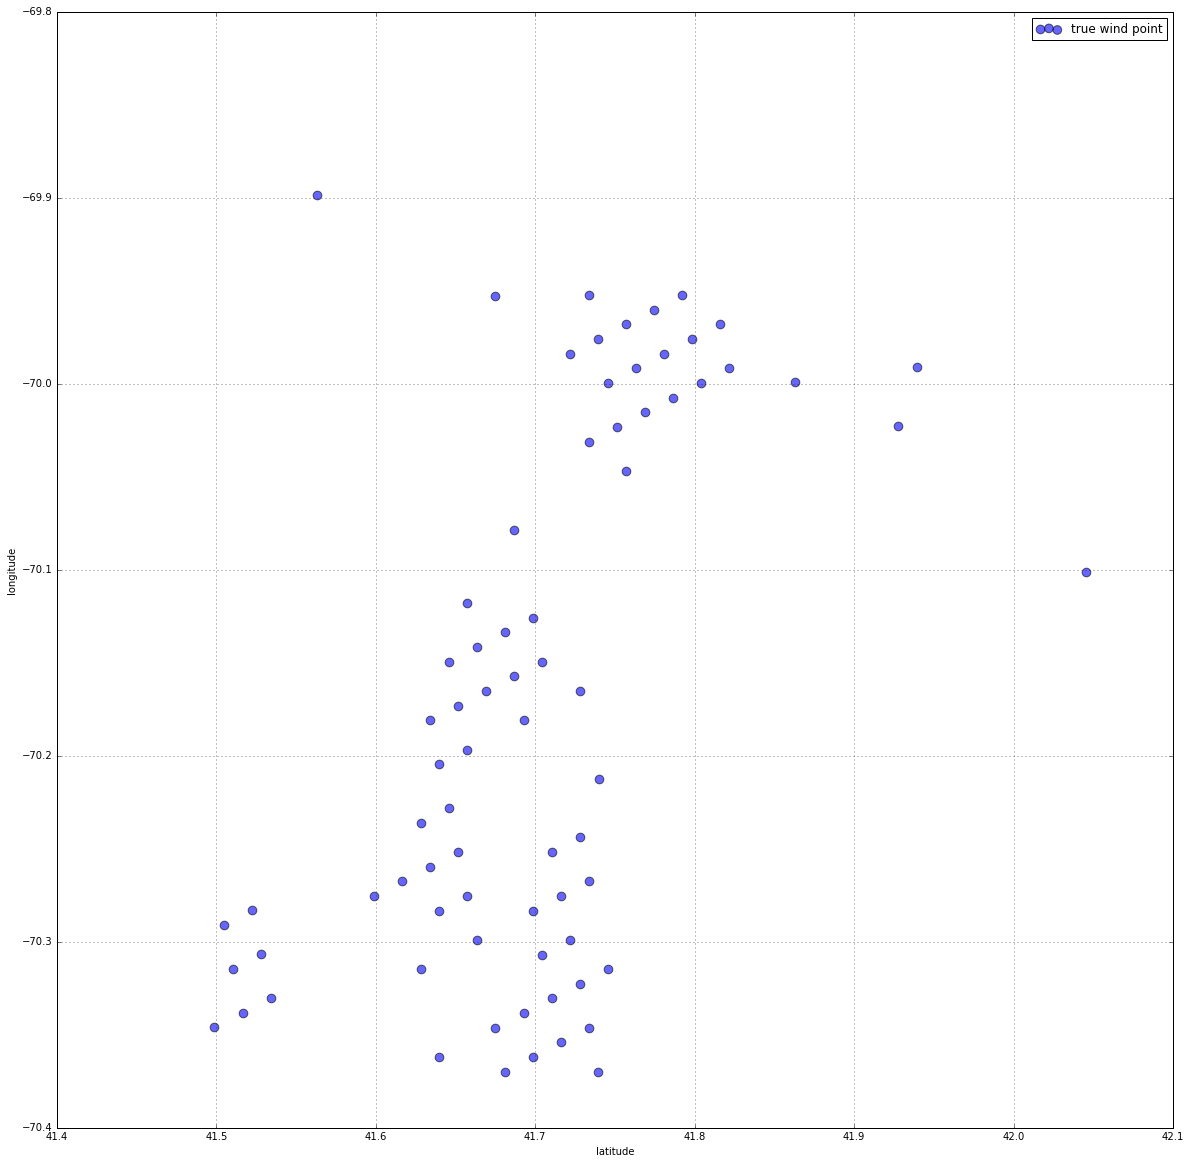

In [4]:
plot_design_matrix(eastern_position, eastern_design_matrix)

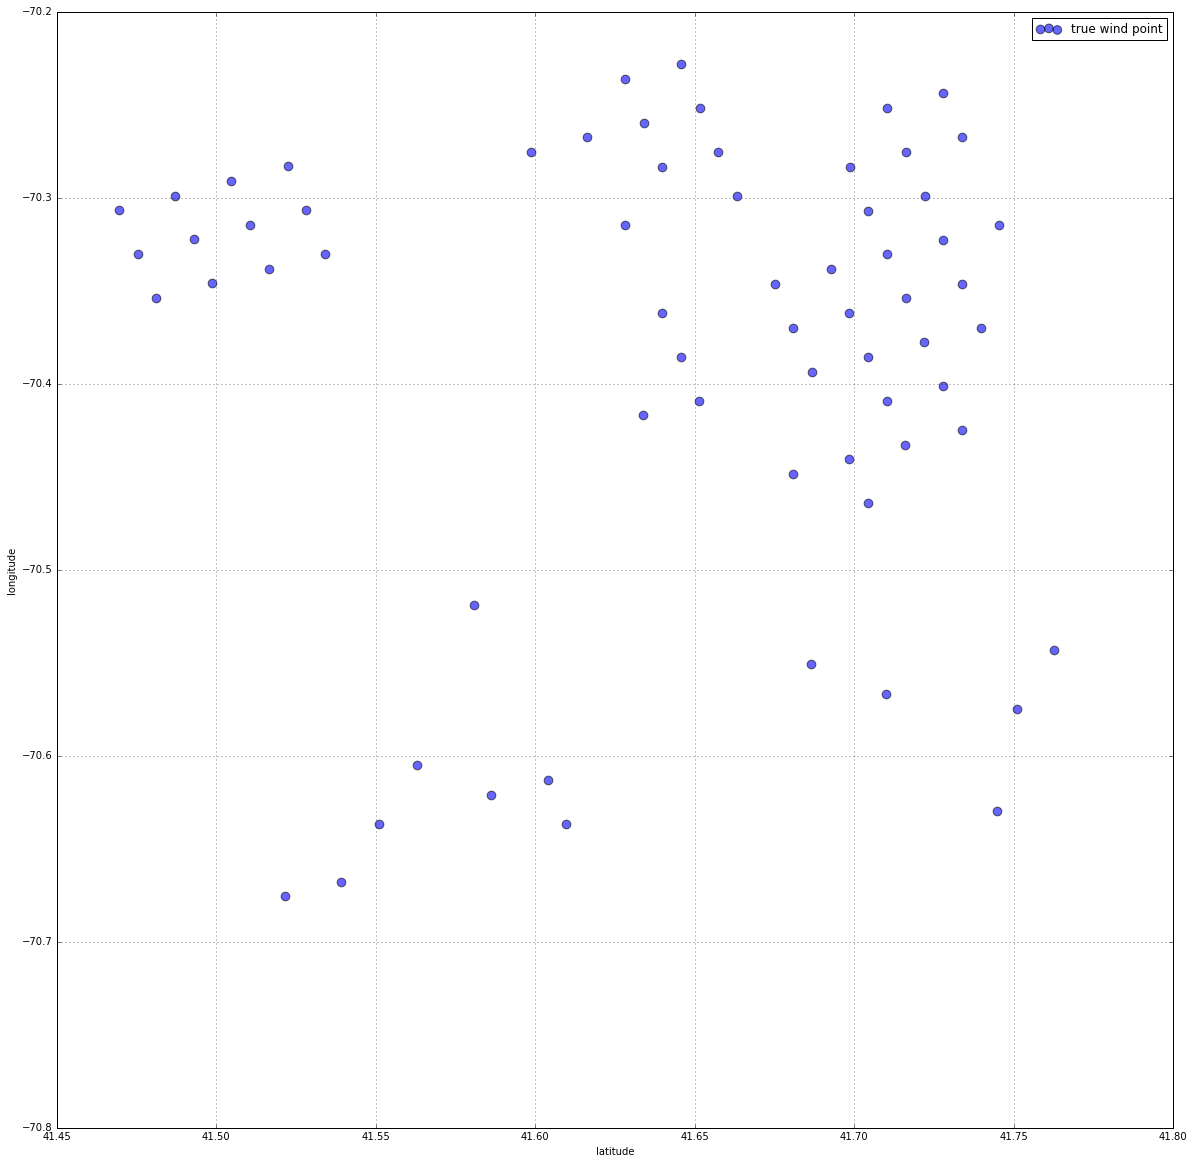

In [5]:
plot_design_matrix(western_position, western_design_matrix)

### 1.1 Feature Engineering

In [6]:
def featureEngineering(features):
    # do some feature engineering
    
    location_factor = 1
    capacity_factor = 1
    
    # inflate the location 
    features[0] = features[0] * location_factor
    features[1] = features[1] * location_factor
    
    # inflate the capacity
    for i in range(2, len(features)):
        features[i] = features[i] * capacity_factor
    
    return features
        
    
    
    

In [7]:
# define the distance heuristic
# this is a helper method that calculate the distance between two points based on the features
def d(a, b):    
    
    lat_lon_a, lat_lon_b = np.array([a[0], a[1]]), np.array([b[0], b[1]])
    physical_distance = np.linalg.norm(lat_lon_a - lat_lon_b)
    print "position a: " + str(lat_lon_a)
    print "position b: " + str(lat_lon_b)
    print "physical_distance " + str(physical_distance)
    
    capacity_a, capacity_b = np.array(a[2:]), np.array(b[2:])
    capacity_distance = np.linalg.norm(capacity_a - capacity_b)
    
    print "capacity_distance " + str(capacity_distance)
      
    return physical_distance + capacity_distance

   
    

## 2. Clustering Algorithms

### 2.1 Hyper-paremeters

There are three ways to determine the number of clusters

1. Use a simple heruistic where $k= \sqrt{n/2}$ where n is the number of wind_points
2. Use the elbow method https://bl.ocks.org/rpgove/0060ff3b656618e9136b
3. Use the gap statistic method http://www.stanford.edu/~hastie/Papers/gap.pdf stats departmen

Option 1 is the quickest way, as it only requires $O(1)$ time. 
Option 2 is more time comsuming because it involves running clustering algorithm multiple times.
Option 3 is the most sophisicated, but it requires a lot of computation within each cluster so it might not scale well when we bring the entire U.S wind points into consideration


In [220]:
n_clusters = 75

#### 2.1.1 Gap Statistic
1. Suppose that we have clustered the data into k clusters $C_1, C_2,...,C_k$ and $n_r = \left|C_r\right|$
2. We defeine the pairwise distance between all two points i, j in a cluster to be: $D_r = \sum_{i,j\in C_r}{d(i,j)} $
3. We define the sum of pairwise distance for all clusters to be: $W_k=\sum_{r=1}^{k}{\dfrac{1}{2n_r}D_r}$
4. $Gap_n(k) = E^*_n\{logW_k\} - logW_k$

Algorithm (https://datasciencelab.wordpress.com/2013/12/27/finding-the-k-in-k-means-clustering/):
1. Cluster the observed data, varying the number of clusters from $k = 1, ..., k_{\mathrm{max}}$, and compute the corresponding W_k.
2. Generate B reference data sets and cluster each of them with varying number of clusters $k = 1, ..., k_{\mathrm{max}}$. Compute the estimated gap statistic $\mathrm{Gap}(k) = (1/B) \sum_{b=1}^B \log W^*_{kb} - \log W_k$.
3. With $\bar{w} = (1/B) \sum_b \log W^*_{kb}$, compute the standard deviation $\mathrm{sd}(k) = [(1/B) \sum_b (\log W^*_{kb} - \bar{w})^2]^{1/2}$ and define $\displaystyle s_k = \sqrt{1+1/B}\,\mathrm{sd}(k)$.
4. Choose the number of clusters as the smallest k such that $\mathrm{Gap}(k) \geq \mathrm{Gap}(k+1) - s_{k+1}$.

In [43]:
def gap_statistic(matrix, lat, lon, min_n_clusters = 1, max_n_clusters = 100, step = 5, B = 5, switch="all"):
    # First generate W_k for the original data
    # print "Generating W_k for original matrix"
    Wk_map = calculate_W_k(matrix, min_n_clusters = min_n_clusters, max_n_clusters = max_n_clusters, step = step)
    
    n_clusters = []
    log_Wk_origins = []
    log_Wk_refs = []
    gaps = []
    s_k_array = []
    # Second generate W_k for the B different reference(random) matrices
    # iterate through each n_clusters
    for n_cluster in range(min_n_clusters, max_n_clusters + step, step):
        #if n_cluster % 10 <= 1:
        #    print "Calculating Gap Statistic for n_cluster = " + str(n_cluster) 
        # logWk for original data points
        log_Wk = np.log(Wk_map[n_cluster])
        log_Wk_origins.append(log_Wk)
        
        log_Wk_ref = 0
        log_Wkb_array = [] # store intermediate result for each b
        # create b sample points
        for b in range(B):
            matrix_ref = random_matrix(matrix, switch, lat, lon)
            # calculate Wkb for each sample b
            Wkb_map_ref = calculate_W_k(matrix_ref, min_n_clusters = n_cluster, max_n_clusters = n_cluster, step = 1)
            log_Wkb = np.log(Wkb_map_ref[n_cluster])
            log_Wk_ref += log_Wkb
            # store Wkb
            log_Wkb_array.append(log_Wkb)
        
        # calculate log_Wk_ref
        log_Wk_ref = float(log_Wk_ref) / float(B)
        log_Wk_refs.append(log_Wk_ref)
        
        # calculate gap
        gaps.append(log_Wk_ref - log_Wk)
        
        # calculate sd(k), based on log_Wk_ref
        sd_k = 0
        for b in range(B):
            log_Wkb = log_Wkb_array[b]
            sd_k += np.square(log_Wkb - log_Wk_ref)
        sd_k = np.sqrt(float(sd_k) / float(B))
        
        # calculate sk
        s_k = np.sqrt(1 + 1.0/B) * sd_k
        s_k_array.append(s_k)
            
        n_clusters.append(n_cluster)
    return (n_clusters, log_Wk_origins, log_Wk_refs, gaps, s_k_array)
       

def random_matrix(matrix, switch="all", lat = (41.5, 42.1), lon = (-70.4, -69.9)):
    """
    switch = geo: generate a random matrix only for latitute and longitute
    switch = all: generate a random matrix for all features
    
    generate a random wind data matrix.
    Each wind data has 2186 features. The first two features are the inflated 
    latitude and longitude
    latitude is in the range of [31, 34]
    longitude is in the range of [-120, -100]
    The rest of the 2184 features are capacities.
    Each of them is in the range [0,1]
    """
    random_matrix = None
    
    if switch == "geo" or switch == "all":
        random_matrix = np.random.rand(matrix.shape[0],matrix.shape[1])
        # need to inflate the position numbers
        for i in range(random_matrix.shape[0]):
        # To sample Unif[a, b), b > a
        # use (b - a) * random_sample() + a
            random_matrix[i][0] = (lat[1] - lat[0]) * np.random.random_sample() + lat[0]
            random_matrix[i][1] = (lon[1] - lon[0]) * np.random.random_sample() + lon[0]
    if switch == "capacity":
        # we add two extra columns for latitute and longitude
        random_matrix = np.random.rand(matrix.shape[0],matrix.shape[1] + 2)
        for i in range(random_matrix.shape[0]):
        # To sample Unif[a, b), b > a
        # use (b - a) * random_sample() + a
            random_matrix[i][0] = (lat[1] - lat[0]) * np.random.random_sample() + lat[0]
            random_matrix[i][1] = (lon[1] - lon[0]) * np.random.random_sample() + lon[0]
            
    return random_matrix






def calculate_W_k(matrix, min_n_clusters, max_n_clusters, step):
    """
    calculate the W_k of the provided data by first clustering them and then 
    compute the pairwise distance between all two points within each cluster
    """
    W_k_map = {}
    for n_cluster in range(min_n_clusters, max_n_clusters + step, step):
        # using the given clustering method to cluster the data
        # kmeans = KMeans(n_clusters=n_cluster, random_state=0)
        # labels = kmeans.fit_predict(matrix)
        
        agglomerative = AgglomerativeClustering(n_clusters=n_cluster, linkage='ward', affinity='euclidean')
        labels = agglomerative.fit_predict(matrix)
        
        clusters = {}
        # First Pass
        # group wind points to their perspective clusters
        for i in range(len(labels)):
            cluster_num = labels[i]
            wind_point = np.copy(matrix[i])
            
            if cluster_num not in clusters:
                members = []
                members.append(wind_point)
                clusters[cluster_num] = members
            else:
                members = clusters[cluster_num]
                members.append(wind_point)
                clusters[cluster_num] = members
                
        W_k = 0
        # Second Pass, calculate the sum of the pair wise distance in each cluster
        for cluster in clusters:
            points = clusters[cluster]
            size = len(points) # the number of wind points in this cluster
            W_k += float(pair_wise(points)) / float(2 * size)
        
        W_k_map[n_cluster] = W_k
    
    return W_k_map
            

def pair_wise(points):
    """
    Calculate the pair_wise distance between all points in a cluster.
    Here we use 2 norm (Euclidean distance)
    """
    return np.sum(sp.spatial.distance.pdist(np.array(points), metric='euclidean'))

        
def plotGapComparsion(n_clusters, log_Wk_refs, log_Wk_origins):
    plt.plot(n_clusters, log_Wk_refs, c="black", alpha=0.7)
    plt.plot(n_clusters, log_Wk_refs, 'ro', label = "$(1/B) \sum_b \log W^*_{kb}$", alpha=0.7) #'ro' means red o

    plt.plot(n_clusters, log_Wk_origins, c="black", alpha=0.7)
    plt.plot(n_clusters, log_Wk_origins, 'bo', label = "$logW_k$", alpha=0.7) #'bo' means blue o
                    
    plt.title("Gap Statistic for Capacity")
    plt.xlabel("n_clusters")
    plt.grid(True)
    plt.legend(loc='center right')
    plt.show()


    # plot the gap statistic
def plotGapStatistic(n_clusters, gaps, s_k_array):
    result = []
    count = 1
    for k in range(len(gaps)):
        if k != len(gaps) - 1:
            result.append(gaps[k] - gaps[k+1] + s_k_array[k+1])
            if (gaps[k] - gaps[k+1] + s_k_array[k+1]) > 0:
                print "Qualifying k! count: " + str(count) + ", n_cluster: " + str(n_clusters[k])
                count += 1

    plt.figure(figsize=(15,15))
    plt.bar(n_clusters[1:], result, align='center', alpha=0.5, label = '$\mathrm{Gap}(k) - \mathrm{Gap}(k+1) + s_{k+1}$')
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.xlabel("n_clusters")
    plt.show()

    
def plotReferenceData(matrix, position, switch, lat = (41.5, 42.1), lon = (-70.4, -69.9)):
    # A comparasion of reference data and true data
    matrix_ref = random_matrix(matrix, switch, lat, lon)
    position_ref = []
    for i in range(matrix_ref.shape[0]):
        position_ref.append([matrix_ref[i][0], matrix_ref[i][1]])                          
    position_ref = np.array(position_ref)


    plt.figure(figsize=(20,20))
    plt.legend(loc=2,fontsize = 'xx-large')

    plt.scatter(position_ref[:,0], position_ref[:,1], c='red', s=75, alpha = 0.6, label = "reference wind point")
    plt.scatter(position[:,0], position[:,1], c='blue', s=75, alpha = 0.6, label = "true wind point")

    plt.grid(True)
    plt.legend(loc='upper right')
    plt.xlabel("latitude")
    plt.ylabel("longitude")

    plt.show()
    

def plotClassification(position, labels):
    """
    Given position of the points and the labels, plot classification
    """
    plt.figure(figsize=(20,20))
    plt.legend(loc=2,fontsize = 'xx-large')

    plt.scatter(position[:,0], position[:,1], c=labels, cmap=plt.cm.spectral, s=50) 
    plt.show()


def plotKmeansClassification(position, labels, kmenas):
    """
    Given position of the points and the labels produced by kmeans, plot classification
    """
    plt.figure(figsize=(20,20))
    plt.legend(loc=2,fontsize = 'xx-large')

    plt.scatter(position[:,0], position[:,1], c=labels, cmap=plt.cm.spectral, s=50)
    
    centroids = kmeans.cluster_centers_

    # We inflate the position features during feature engineering, so we need to restore them back. 
    centroids_position = np.array([[centroids[i][0], centroids[i][1]] for i in range(centroids.shape[0])])

    plt.scatter(centroids_position[:, 0], centroids_position[:, 1],
            marker='x', s=169, linewidths=3,
            color='black', zorder=10)
    plt.show()


def full_run_with_graphs(position, matrix, lat, lon, min_n_clusters = 1, max_n_clusters = 100, step = 1, B = 5, switch="all"):
    """
    A full run of one phase clustering with gap statistic and 
    graphs.
    """
    # Calculate parameters
    n_clusters, log_Wk_origins, log_Wk_refs, gaps, s_k_array = gap_statistic(matrix=matrix, lat=lat, lon=lon, min_n_clusters = 1, max_n_clusters = max(int(np.sqrt(matrix.shape[0])), min(80, matrix.shape[0])), step = step, B = B, switch=switch)
    # Plot
    plotGapComparsion(n_clusters, log_Wk_refs, log_Wk_origins)
    plotGapStatistic(n_clusters, gaps, s_k_array)
    plotReferenceData(matrix, position, switch = switch, lat=lat, lon=lon)

    
def full_run():
    """
    A full run of one phase clustering with gap statistic.
    """

/Users/zhjin/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: divide by zero encountered in log
/Users/zhjin/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:27: RuntimeWarning: divide by zero encountered in log
/Users/zhjin/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:37: RuntimeWarning: invalid value encountered in double_scalars
/Users/zhjin/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:43: RuntimeWarning: invalid value encountered in double_scalars


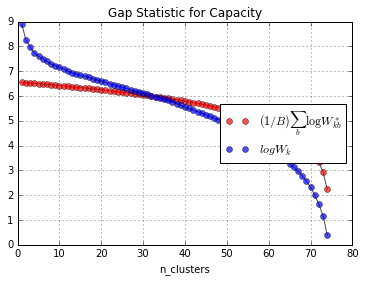

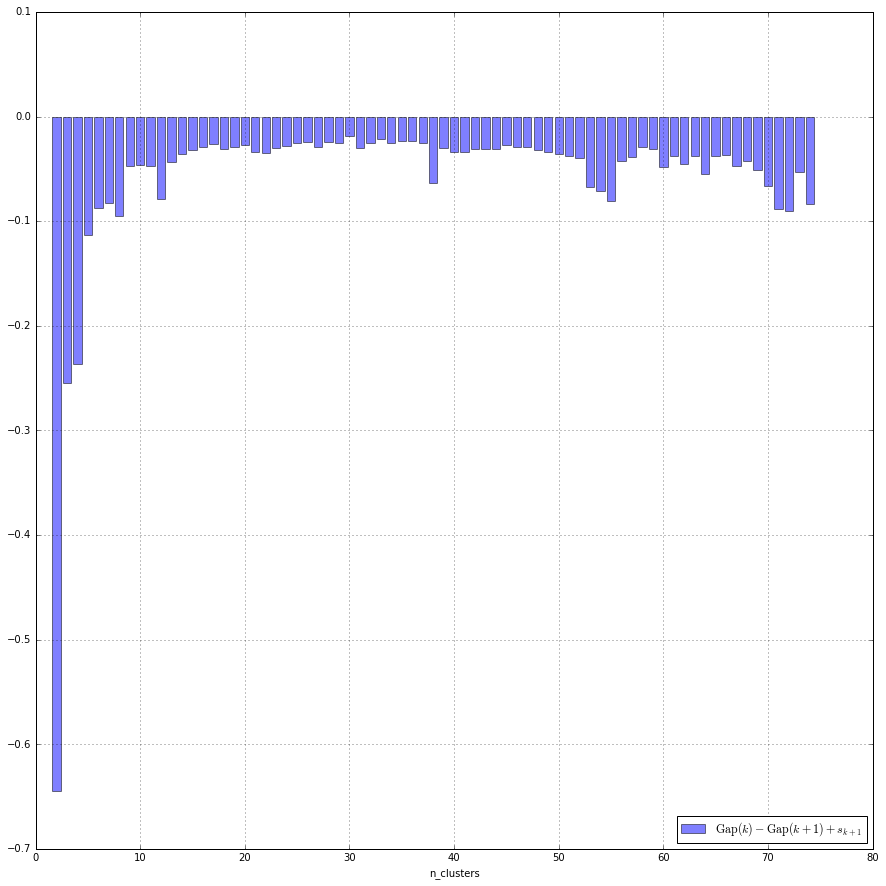

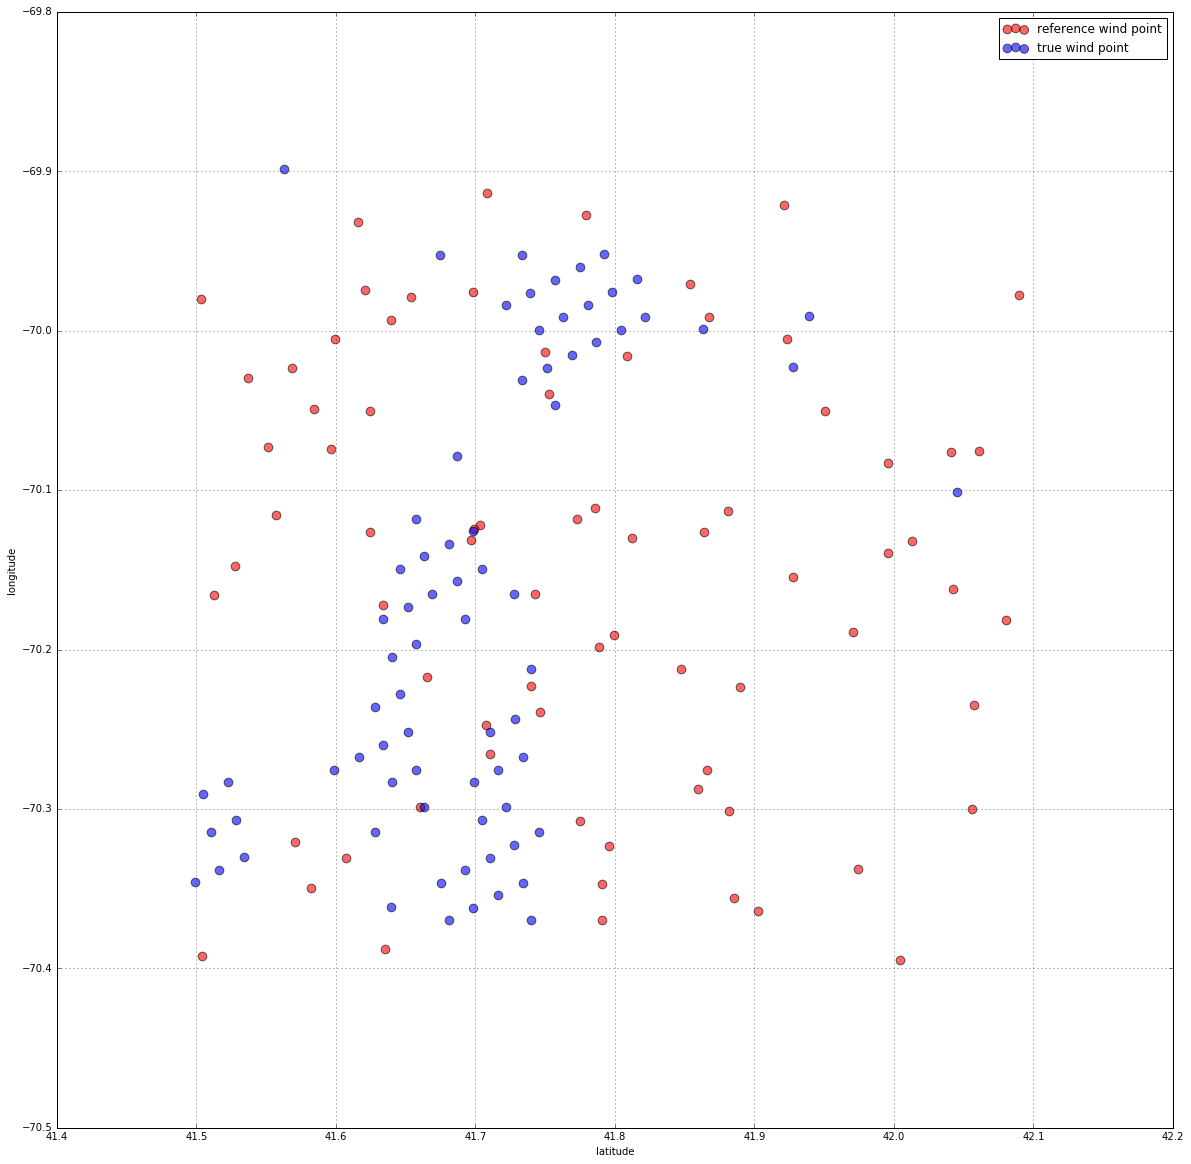

In [45]:
full_run_with_graphs(eastern_position, eastern_design_matrix, lat = (41.5, 42.1), lon = (-70.4, -69.9))

/Users/zhjin/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: divide by zero encountered in log
/Users/zhjin/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:27: RuntimeWarning: divide by zero encountered in log
/Users/zhjin/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:37: RuntimeWarning: invalid value encountered in double_scalars
/Users/zhjin/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:43: RuntimeWarning: invalid value encountered in double_scalars


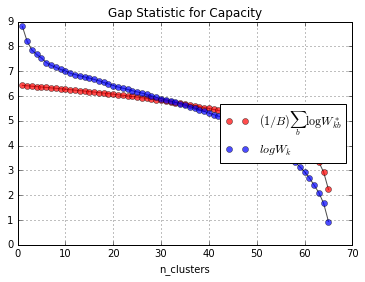

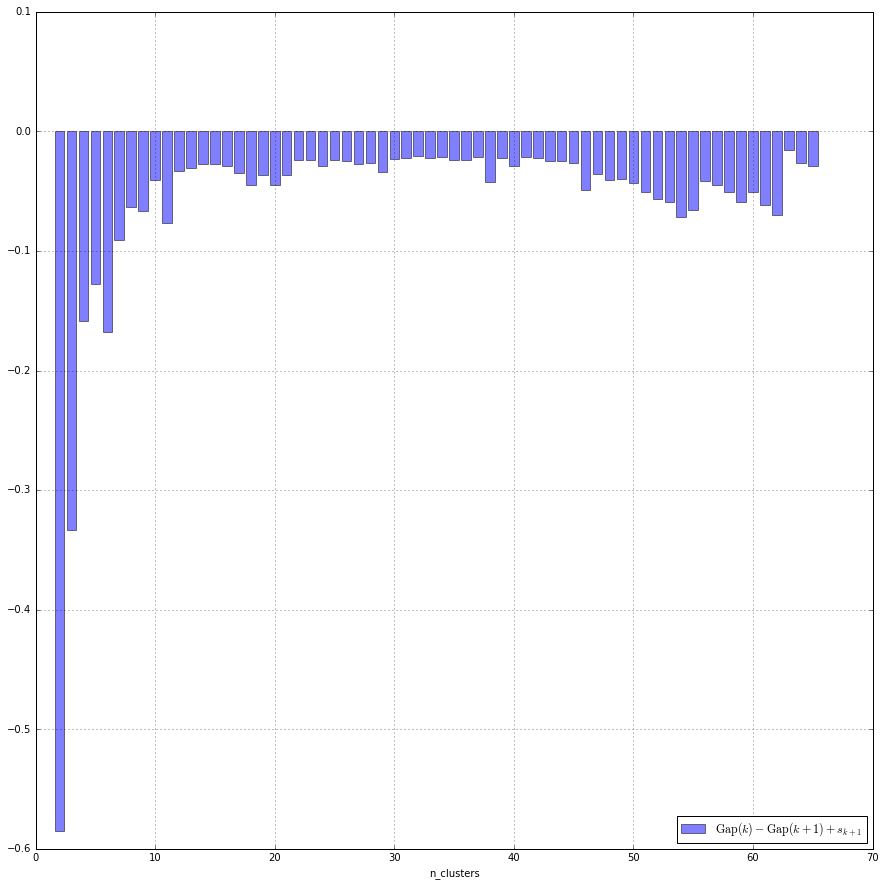

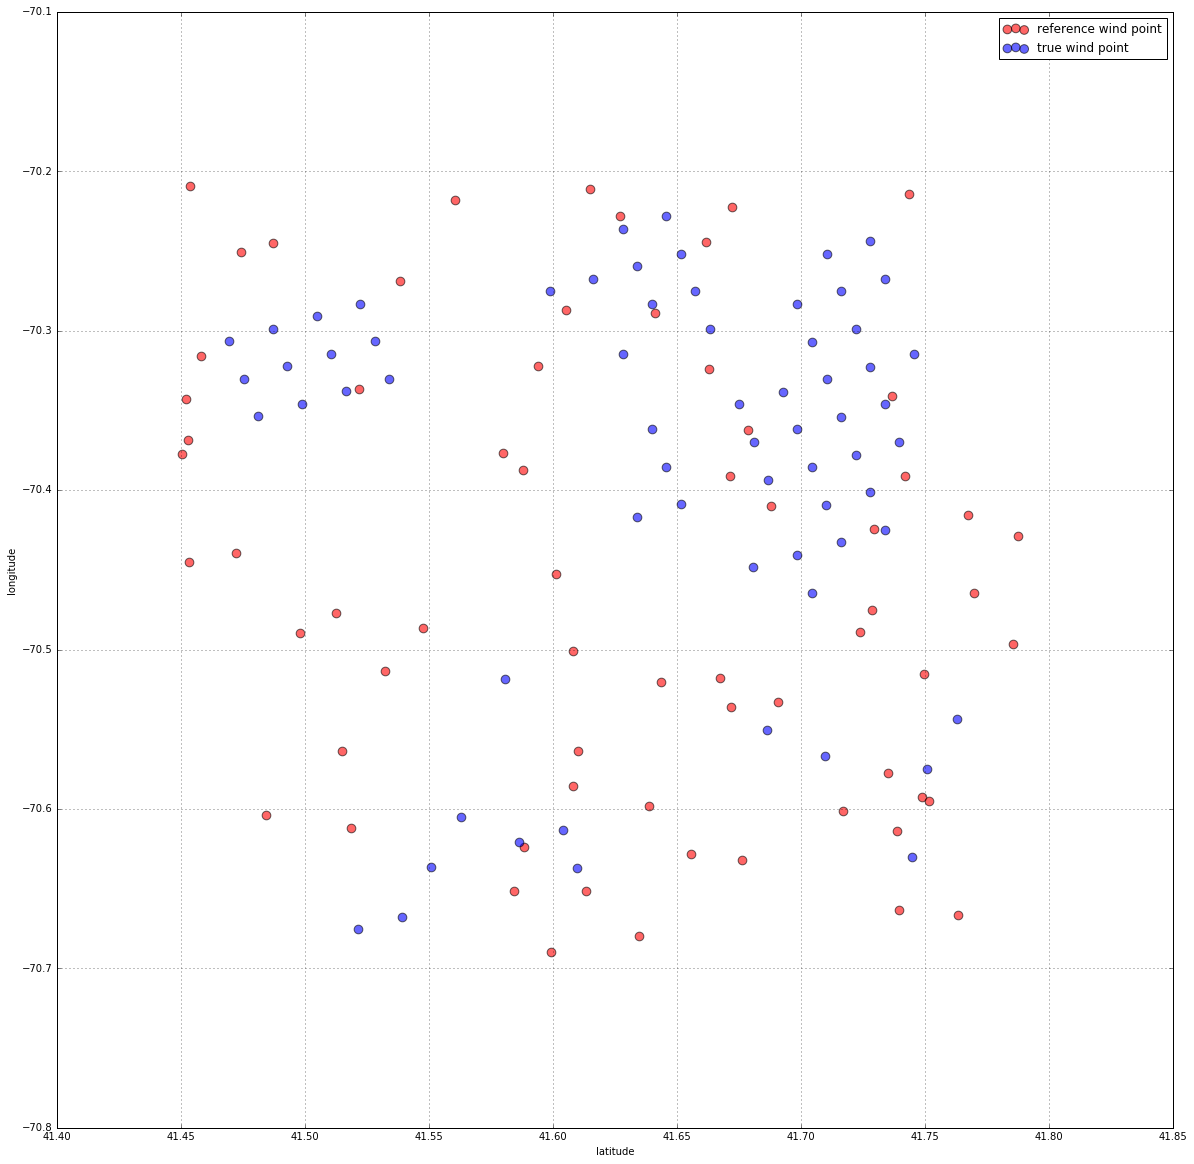

In [44]:
full_run_with_graphs(western_position, western_design_matrix, lat=(41.45, 41.80), lon=(-70.7, -70.2))

In [112]:
n_clusters, log_Wk_origins, log_Wk_refs, gaps, s_k_array = gap_statistic(matrix)

Generating W_k for original matrix
Calculating Gap Statistic for n_cluster = 20
Calculating Gap Statistic for n_cluster = 30
Calculating Gap Statistic for n_cluster = 40
Calculating Gap Statistic for n_cluster = 50
Calculating Gap Statistic for n_cluster = 60
Calculating Gap Statistic for n_cluster = 70
Calculating Gap Statistic for n_cluster = 80
Calculating Gap Statistic for n_cluster = 90
Calculating Gap Statistic for n_cluster = 100


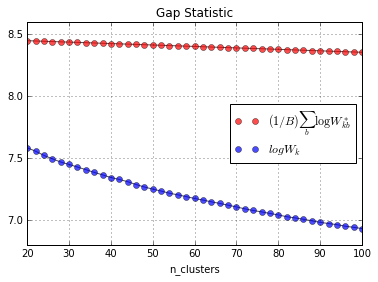

In [113]:
plt.plot(n_clusters, log_Wk_refs, c="black", alpha=0.7)
plt.plot(n_clusters, log_Wk_refs, 'ro', label = "$(1/B) \sum_b \log W^*_{kb}$", alpha=0.7) #'ro' means red o

plt.plot(n_clusters, log_Wk_origins, c="black", alpha=0.7)
plt.plot(n_clusters, log_Wk_origins, 'bo', label = "$logW_k$", alpha=0.7) #'bo' means blue o
                    
plt.title("Gap Statistic")
plt.xlabel("n_clusters")
plt.grid(True)
plt.legend(loc='center right')
plt.show()

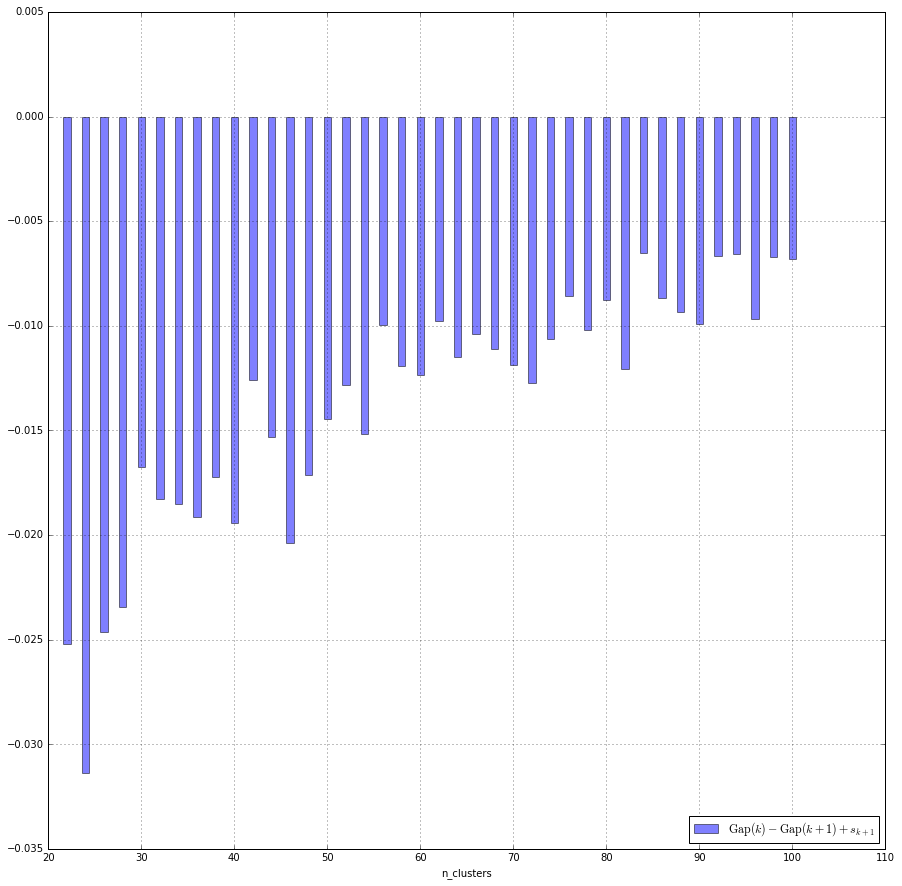

In [114]:
# plot the gap statistic
result = []
for k in range(len(gaps)):
    if k != len(gaps) - 1:
        result.append(gaps[k] - gaps[k+1] + s_k_array[k+1])
    
plt.figure(figsize=(15,15))
plt.bar(n_clusters[1:], result, align='center', alpha=0.5, label = '$\mathrm{Gap}(k) - \mathrm{Gap}(k+1) + s_{k+1}$')
plt.grid(True)
plt.legend(loc='lower right')
plt.xlabel("n_clusters")
plt.show()
    

/Users/zhjin/anaconda/lib/python2.7/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


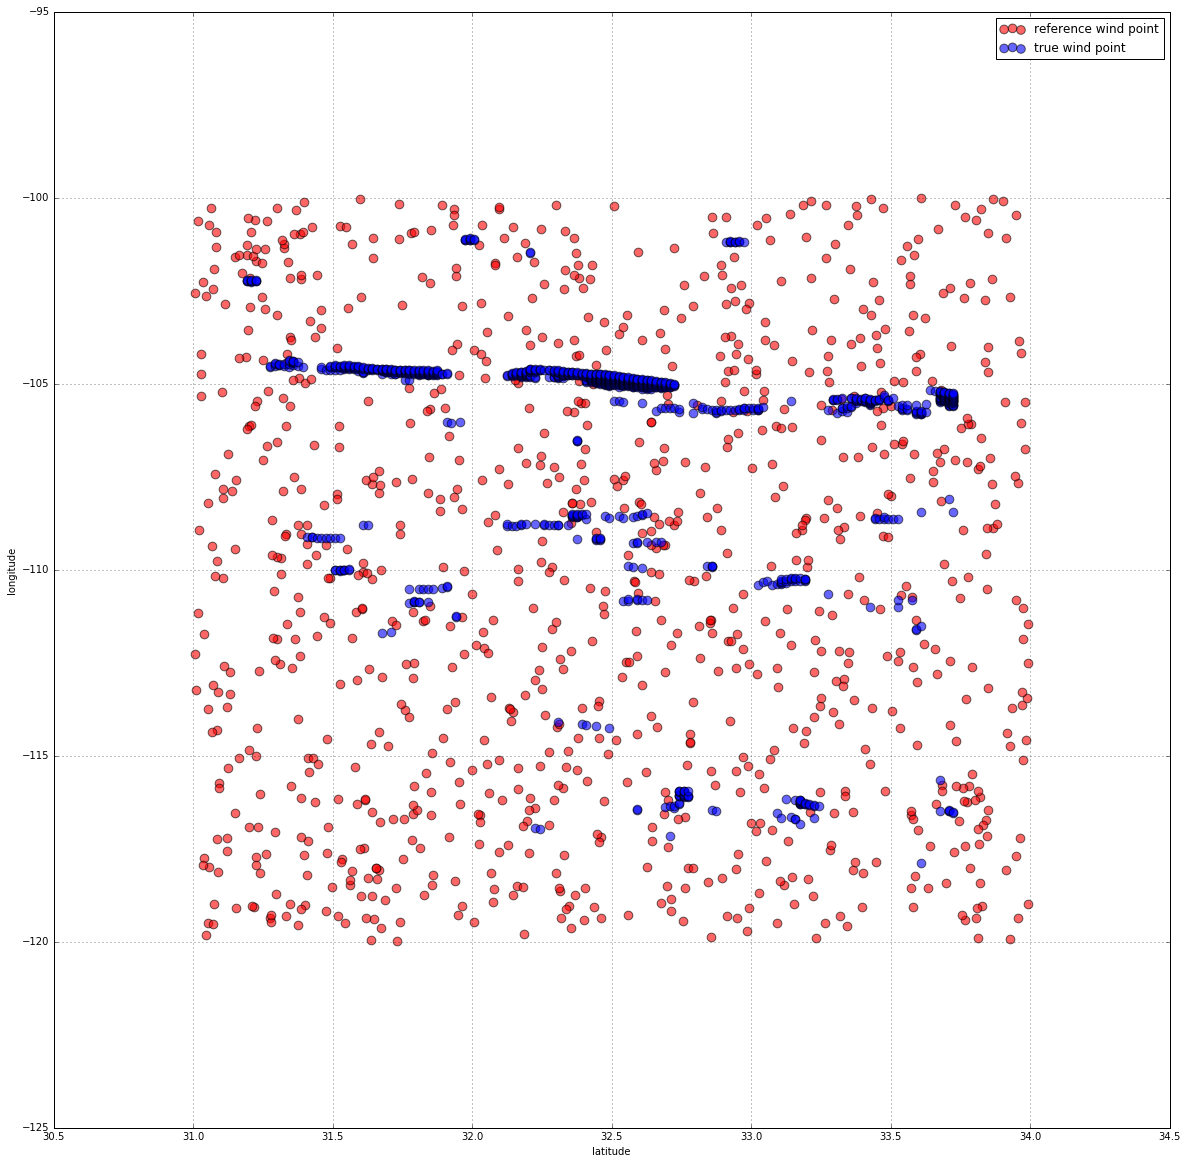

In [18]:
# A comparasion of reference data and true data
matrix_ref = random_matrix(matrix)
position_ref = []
for i in range(matrix_ref.shape[0]):
    position_ref.append([matrix_ref[i][0], matrix_ref[i][1]])
position_ref = np.array(position_ref)


plt.figure(figsize=(20,20))
plt.legend(loc=2,fontsize = 'xx-large')

plt.scatter(position_ref[:,0], position_ref[:,1], c='red', s=75, alpha = 0.6, label = "reference wind point")
plt.scatter(position[:,0], position[:,1], c='blue', s=75, alpha = 0.6, label = "true wind point")

plt.grid(True)
plt.legend(loc='upper right')
plt.xlabel("latitude")
plt.ylabel("longitude")

plt.show()

### 2.2 Agglomerative Clustering

In [221]:
# apply Agglomerative Clustering
ward = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward', affinity='euclidean')

agglomerative_labels = ward.fit_predict(matrix)



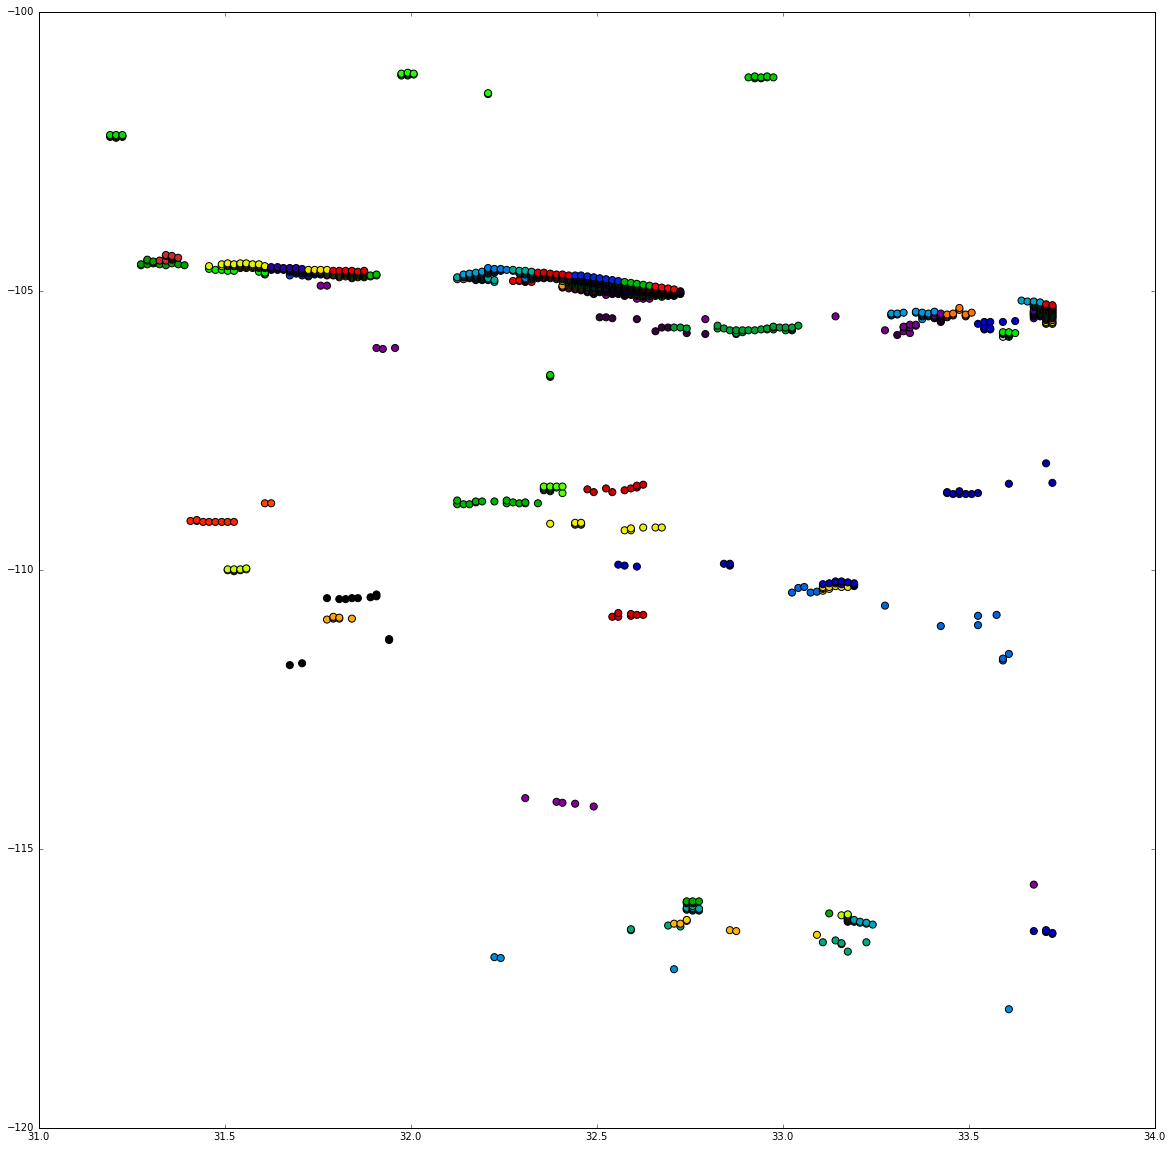

In [222]:
plt.figure(figsize=(20,20))
plt.legend(loc=2,fontsize = 'xx-large')

plt.scatter(position[:,0], position[:,1], c=agglomerative_labels, cmap=plt.cm.spectral, s=50)

plt.show()

#### 2.2.1 Loss Function
Based on the label, we calculate the the root mean squre error(RMSE).

$\sum^K_{k=1} \sum_{i\in c_k} || x_i - \mu_k ||^2 \ \ \ \ \ \rm Euclidean \ distance$

In addition, we implemented the gap statistic method to determine the optimal number of k.
Refer to this paper published at Stanford http://www.stanford.edu/~hastie/Papers/gap.pdf

In [1]:
def general_rmse(matrix, labels):
    """
    Given a wind point data matrix and the clustering labels,
    calculate the root mean square error of the clustering.
    """
    clusters = {}
    # First Pass
    # group wind points to their perspective clusters
    for i in range(len(labels)):
        cluster_num = labels[i]
        wind_point = np.copy(matrix[i])

        if cluster_num not in clusters:
            members = []
            members.append(wind_point)
            clusters[cluster_num] = members
        else:
            members = clusters[cluster_num]
            members.append(wind_point)
            clusters[cluster_num] = members


    clusters_rmse = 0
    # Second Pass, calculate the mean point and the rmse 
    for cluster_num in clusters:
        cluster = np.array(clusters[cluster_num])
        center = np.mean(cluster, axis=0)
        # make it a column vector instead of a row vector
        center.shape = (center.shape[0], 1)
    
        for point in cluster:
            # make it a column vector instead of a row vector
            point.shape = (point.shape[0], 1)
            rmse = np.linalg.norm(point - center)
            clusters_rmse += rmse

    return clusters_rmse
        
    
    
    
    
    


In [104]:
general_rmse(matrix, agglomerative_labels)

4372.7898599700593

In [58]:
#agglomerative_labels

### 2.3 K-means

In [180]:
kmeans = KMeans(n_clusters=n_clusters, random_state=0, max_iter=500, n_init = 40)

kmeans_labels = kmeans.fit_predict(matrix)


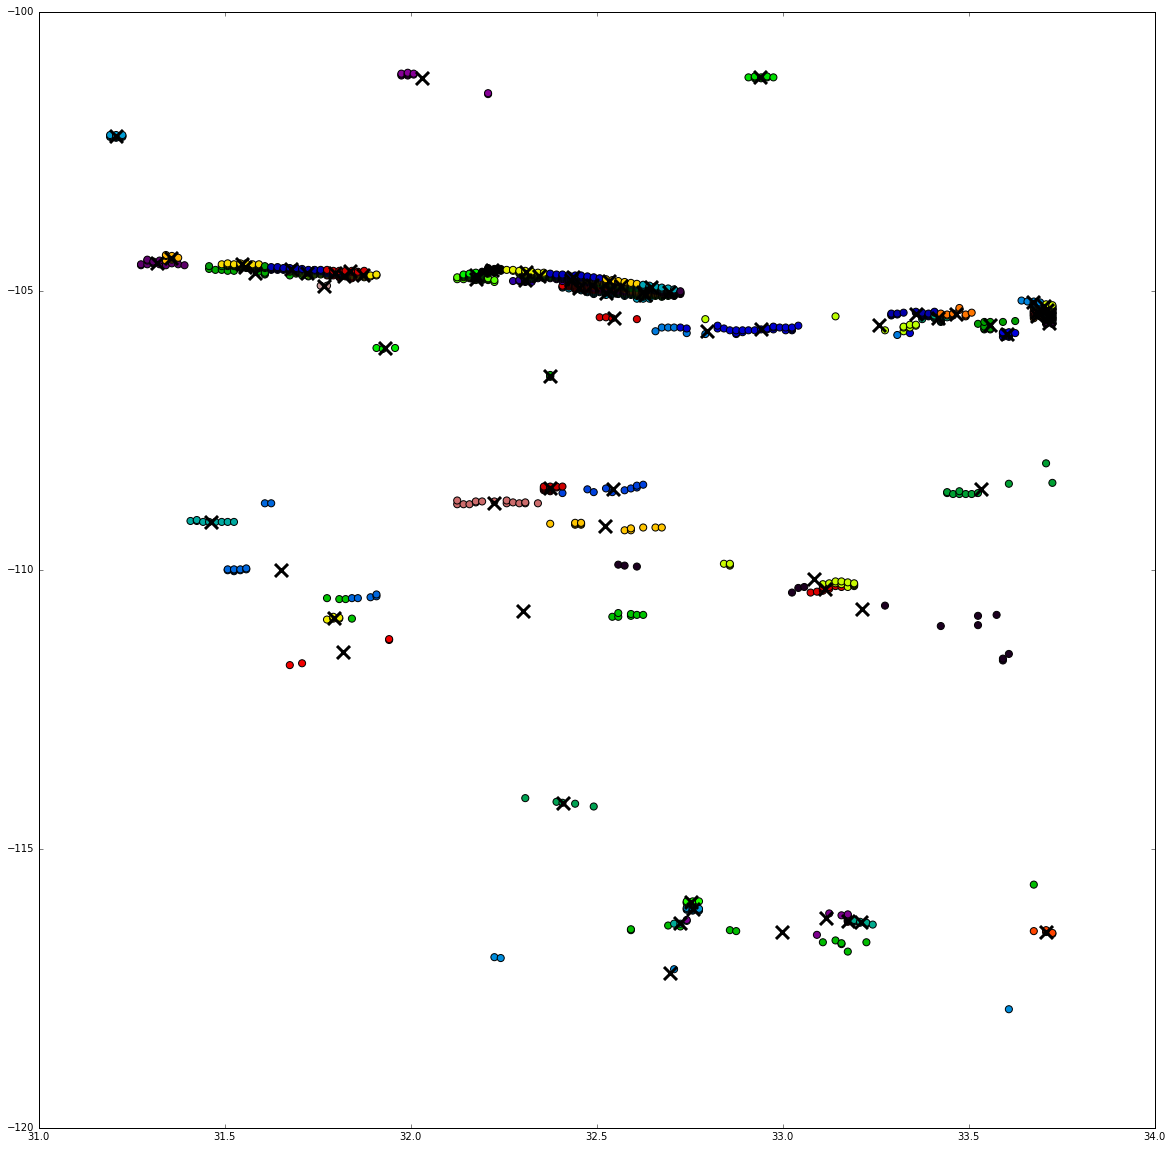

In [187]:
plt.figure(figsize=(20,20))
plt.legend(loc=2,fontsize = 'xx-large')

plt.scatter(position[:,0], position[:,1], c=kmeans_labels, cmap=plt.cm.spectral, s=50)

centroids = kmeans.cluster_centers_

# We inflate the position features during feature engineering, so we need to restore them back. 
centroids_position = np.array([[centroids[i][0], centroids[i][1]] for i in range(centroids.shape[0])])

plt.scatter(centroids_position[:, 0], centroids_position[:, 1],
            marker='x', s=169, linewidths=3,
            color='black', zorder=10)

plt.show()

#### 2.3.1 Loss Function

$\sum^K_{k=1} \sum_{i\in c_k} || x_i - \mu_k ||^2 \ \ \ \ \ \rm Euclidean \ distance$

In [175]:
def kmean_rmse(matrix, labels, centroids):
    """
    Parameters
    ----------
    matrix : n*d np.array
        n*d design matrix
    labels : np.array
        the clustering by kmeans. Each wind-point has a label, which is the cluster it belongs
    centroids: np.array
        the centroids by kmeans
    Given a wind point data matrix and the k-mean centers
    calculate the root mean square error of the clustering.
    """
    clusters = {}
    # First Pass
    # group wind points to their perspective clusters
    for i in range(len(labels)):
        cluster_num = labels[i]
        wind_point = np.copy(matrix[i])

        if cluster_num not in clusters:
            members = []
            members.append(wind_point)
            clusters[cluster_num] = members
        else:
            members = clusters[cluster_num]
            members.append(wind_point)
            clusters[cluster_num] = members


    clusters_rmse = 0
    # Second Pass, calculate the rmse based on centroids
    for cluster_num in clusters:
        cluster = np.array(clusters[cluster_num])
        centroid = centroids[cluster_num]
        centroid.shape = (centroid.shape[0], 1)
        
        
        for point in cluster:
            # make it a column vector instead of a row vector
            point.shape = (point.shape[0], 1)
            rmse = np.linalg.norm(point - centroid)
            clusters_rmse += rmse
    
    
    return clusters_rmse
    
    
    
    

In [177]:
kmean_rmse(matrix, kmeans_labels, kmeans.cluster_centers_)

4204.9850403463061

### 2.4 Spectral Clustering

In [109]:
spectral = SpectralClustering(n_clusters=n_clusters,
                                eigen_solver="arpack",
                                affinity="nearest_neighbors")

spectral_labels = spectral.fit_predict(matrix)

In [111]:
general_rmse(matrix, spectral_labels)

4480.7875003304471

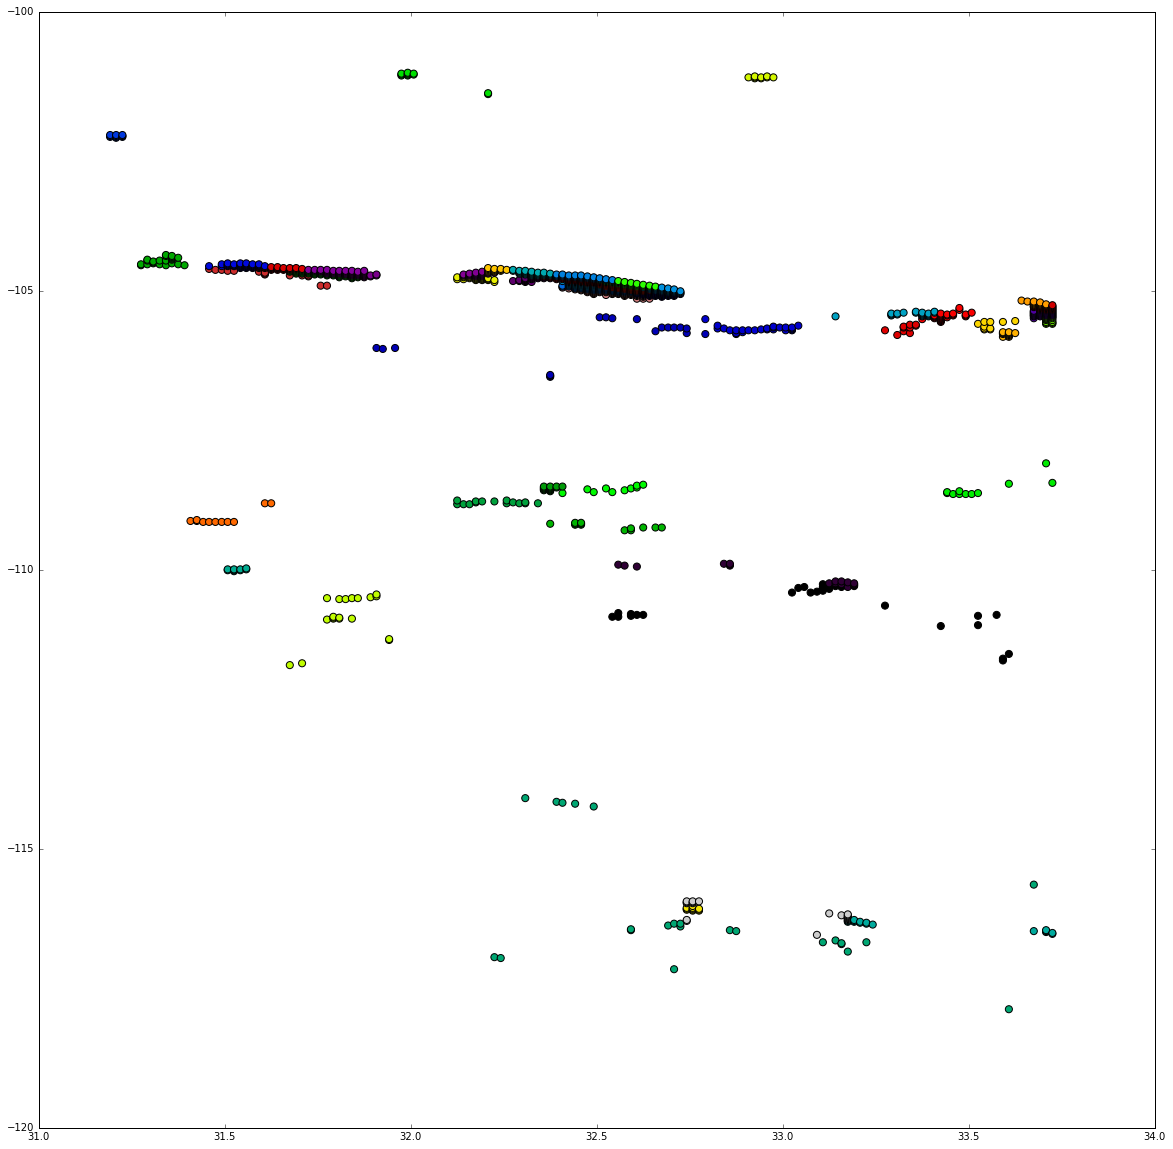

In [112]:
plt.figure(figsize=(20,20))
plt.legend(loc=2,fontsize = 'xx-large')

plt.scatter(position[:,0], position[:,1], c=spectral_labels, cmap=plt.cm.spectral, s=50)

plt.show()

## 3 Cross Validation and Comparative Analysis

### 3.1 Cross Validation

In [186]:
def agglomerative_clustering_validation(matrix, min_n_clusters = 10, max_n_clusters = 100, step = 5, 
                                        linkages = ["ward", "complete", "average"], 
                                        affinities = ["euclidean", "l1", "l2", "manhattan", "cosine"]):
    """
    Parameters
    ----------
    matrix : n * d np.array
        the design matrix
    min_n_clusters : integer
        the minimum number of clusters we consider.
    max_n_clusters : integer
        the maximum number of clusters we consider.
    step: integer
        the step size of increment of the number of clusters
        For example, if min_n_clusters = 10, max_n_clusters = 100, then we will cross validite the number
        of clusters from 10 to 100, increment at a unit of 5. So we consider 10, 15, 20,...,100.  
    linkage: array of strings, each represent a linkage method
        ward minimizes the variance of the clusters being merged.
        average uses the average of the distances of each observation of the two sets.
        complete or maximum linkage uses the maximum distances between all observations of the two sets.
    affinity: array of strings, each represent an affinity
        Metric used to compute the linkage.
    """
    for linkage in linkages:
        for affinity in affinities:
            if linkage == "ward" and affinity != "euclidean":
                continue
            n_clusters = []
            rmse = []
            for n_cluster in range(min_n_clusters, max_n_clusters + step, step):
                agglomerative = AgglomerativeClustering(n_clusters=n_cluster, linkage=linkage, affinity=affinity)
                agglomerative_labels = agglomerative.fit_predict(matrix)
                n_clusters.append(n_cluster)
                rmse.append(general_rmse(matrix, agglomerative_labels))
            # plot the data
            plt.plot(n_clusters, rmse, c="black")
            plt.plot(n_clusters, rmse, 'ro')
            plt.title("agglomerative_clustering_" + linkage + "_" + affinity)
            plt.ylabel("Root Mean Square Error")
            plt.xlabel("n_clusters")
            plt.grid(True)
            plt.show()
              
                
def spectral_clustering_validation(matrix, min_n_clusters = 10, max_n_clusters = 100, 
                                   step = 5, eigen_solvers = ["arpack", None], 
                                  affinities = ["sigmoid", "polynomial", "poly", "linear", "cosine", "nearest_neighbors"]):
    """
    Parameters
    ----------
    matrix : n * d np.array
        the design matrix
    min_n_clusters : integer
        the minimum number of clusters we consider.
    max_n_clusters : integer
        the maximum number of clusters we consider.
    step: integer
        the step size of increment of the number of clusters
        For example, if min_n_clusters = 10, max_n_clusters = 100, then we will cross validite the number
        of clusters from 10 to 100, increment at a unit of 5. So we consider 10, 15, 20,...,100.  
    linkage: array of strings, each represent a linkage method
        ward minimizes the variance of the clusters being merged.
        average uses the average of the distances of each observation of the two sets.
        complete or maximum linkage uses the maximum distances between all observations of the two sets.
    affinity: array of strings, each represent an affinity
        Metric used to compute the linkage.
    """
    for eigen_solver in eigen_solvers:
        for affinity in affinities:
            n_clusters = []
            rmse = []
            for n_cluster in range(min_n_clusters, max_n_clusters + step, step):
                spectral = SpectralClustering(n_clusters=n_cluster,
                                                eigen_solver=eigen_solver,
                                                affinity=affinity)
                spectral_labels = spectral.fit_predict(matrix)
                n_clusters.append(n_cluster)
                rmse.append(general_rmse(matrix, spectral_labels))
            # plot the data
            plt.plot(n_clusters, rmse, c="black")
            plt.plot(n_clusters, rmse, 'go')
            plt.title("spectral_clustering_" + str(eigen_solver) + "_" + affinity)
            plt.ylabel("Root Mean Square Error")
            plt.xlabel("n_clusters")
            plt.grid(True)
            plt.show()

            
def kmeans_clustering_validation(matrix, min_n_clusters = 10, max_n_clusters = 100, step = 5):
    """
    Parameters
    ----------
    matrix : n * d np.array
        the design matrix
    min_n_clusters : integer
        the minimum number of clusters we consider.
    max_n_clusters : integer
        the maximum number of clusters we consider.
    step: integer
        the step size of increment of the number of clusters
        For example, if min_n_clusters = 10, max_n_clusters = 100, then we will cross validite the number
        of clusters from 10 to 100, increment at a unit of 5. So we consider 10, 15, 20,...,100.  
    """
    n_clusters = []
    rmse = []
    for n_cluster in range(min_n_clusters, max_n_clusters + step, step):
        kmeans = KMeans(n_clusters=n_cluster, random_state=0)
        kmeans_labels = kmeans.fit_predict(matrix)
        centroids = kmeans.cluster_centers_
        
        n_clusters.append(n_cluster)
        rmse.append(kmean_rmse(matrix, kmeans_labels, centroids))
        
    # plot the data
    plt.plot(n_clusters, rmse, c="black")
    plt.plot(n_clusters, rmse, 'bo')
    plt.title("kmeans_clustering")
    plt.ylabel("Root Mean Square Error")
    plt.xlabel("n_clusters")
    plt.grid(True)
    plt.show()

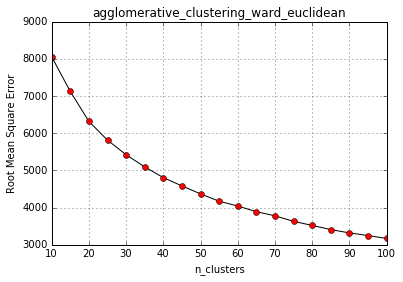

KeyboardInterrupt: 

In [187]:
agglomerative_clustering_validation(matrix)

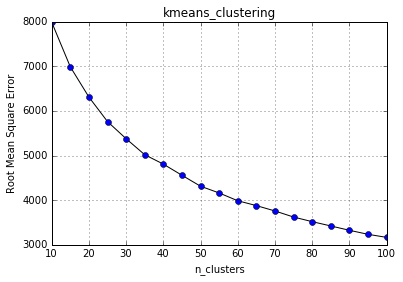

In [139]:
kmeans_clustering_validation(matrix)

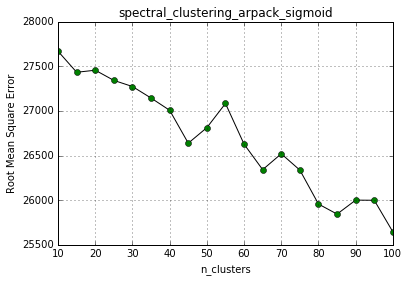

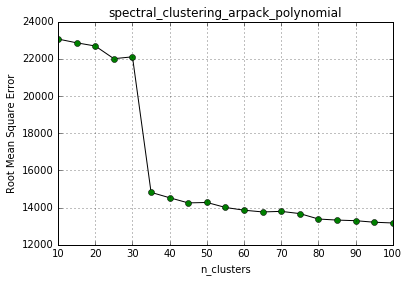

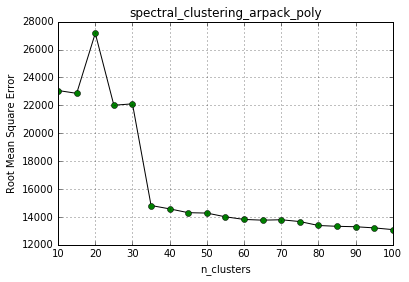

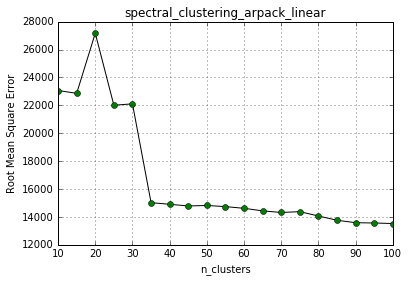

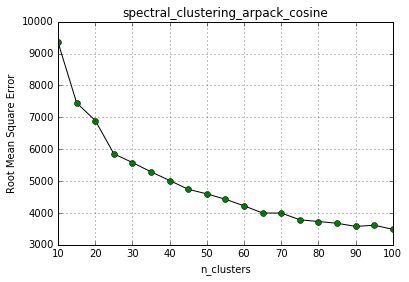

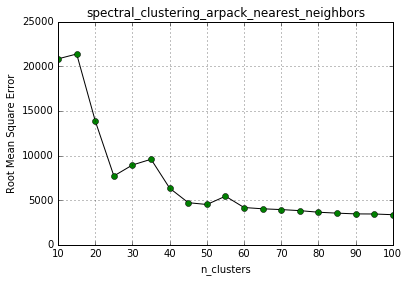

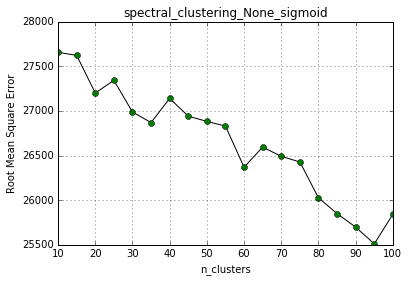

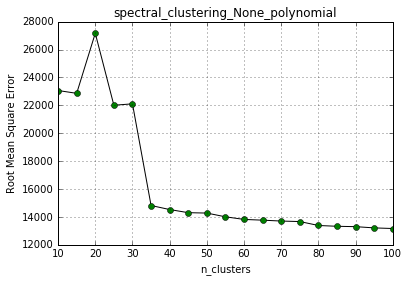

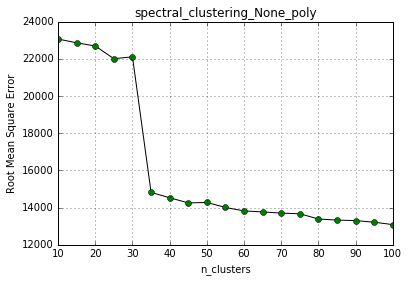

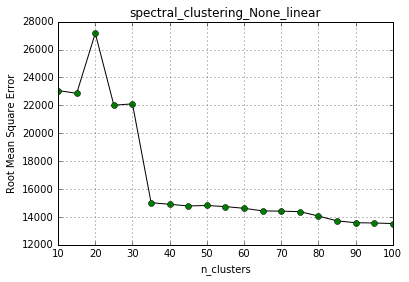

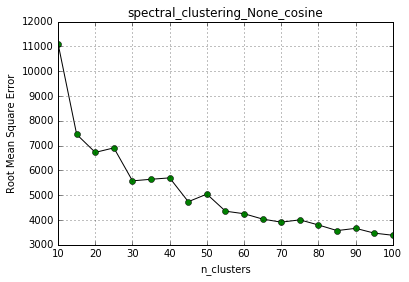

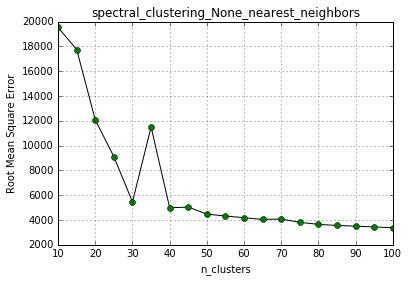

In [137]:
spectral_clustering_validation(matrix)

In [ ]:
hyperParemeters = [{}]

### 3.2 Comparative Analysis 

In [200]:
def comparative_analysis(matrix, min_n_clusters = 10, max_n_clusters = 100, step = 5, 
                         linkages_agglomerative = ["ward", "complete", "average"], affinities_agglomerative = ["euclidean", "l2"],
                        eigen_solvers = ["arpack", None], affinities_spectral = ["cosine", "nearest_neighbors"]):
    """
    Parameters
    ----------
    matrix : n * d np.array
        the design matrix
    min_n_clusters : integer
        the minimum number of clusters we consider.
    max_n_clusters : integer
        the maximum number of clusters we consider.
    step: integer
        the step size of increment of the number of clusters
        For example, if min_n_clusters = 10, max_n_clusters = 100, then we will cross validite the number
        of clusters from 10 to 100, increment at a unit of 5. So we consider 10, 15, 20,...,100.  
    linkages_agglomerative: array of strings, each represent a linkage method
        ward minimizes the variance of the clusters being merged.
        average uses the average of the distances of each observation of the two sets.
        complete or maximum linkage uses the maximum distances between all observations of the two sets.
    affinities_agglomerative: array of strings, each represent an affinity
        Metric used to compute the linkage.
    eigen_solvers:
        
    affinities_spectral:
        
    
    """
    for linkage_agglomerative in linkages_agglomerative: # this parameter is unique to the agglomerative_clustering
        for affinity_agglomerative in affinities_agglomerative: # this parameter is unique to the agglomerative_clustering
            for eigen_solver in eigen_solvers:
                for affinity_spectral in affinities_spectral:
                    if linkage_agglomerative == "ward" and affinity_agglomerative != "euclidean":
                        continue
                    n_clusters = []
                    rmse_agglomerative = []
                    rmse_kmeans = []
                    rmse_spectral = []
                    for n_cluster in range(min_n_clusters, max_n_clusters + step, step):
                        n_clusters.append(n_cluster)
                        # run the agglomerative_clustering
                        agglomerative = AgglomerativeClustering(n_clusters=n_cluster, linkage=linkage_agglomerative, affinity=affinity_agglomerative)
                        agglomerative_labels = agglomerative.fit_predict(matrix)
                        rmse_agglomerative.append(general_rmse(matrix, agglomerative_labels))
                
                        # run the kmeans algorithm
                        kmeans = KMeans(n_clusters=n_cluster, random_state=0, max_iter=500, n_init = 40)
                        kmeans_labels = kmeans.fit_predict(matrix)
                        centroids = kmeans.cluster_centers_
                        rmse_kmeans.append(kmean_rmse(matrix, kmeans_labels, centroids))
                        
                        # spectral
                        spectral = SpectralClustering(n_clusters=n_cluster,
                                                eigen_solver=eigen_solver,
                                                affinity=affinity_spectral)
                        spectral_labels = spectral.fit_predict(matrix)
                        rmse_spectral.append(general_rmse(matrix, spectral_labels))
                
                    # plot the data
                    # agglomerative_clustering
                    plt.plot(n_clusters, rmse_agglomerative, c="black", alpha=0.7)
                    plt.plot(n_clusters, rmse_agglomerative, 'ro', label = "agglomerative_" + linkage_agglomerative + "_" + affinity_agglomerative, alpha=0.7) #'ro' means red o
                    # kmeans
                    plt.plot(n_clusters, rmse_kmeans, c="black", alpha=0.7)
                    plt.plot(n_clusters, rmse_kmeans, 'bo', label = "kmeans", alpha=0.7) #'bo' means blue o
                    # Spectral
                    plt.plot(n_clusters, rmse_spectral, c="black", alpha=0.7)
                    plt.plot(n_clusters, rmse_spectral, 'go', label = "spectral_" + str(eigen_solver) + "_" + affinity_spectral, alpha=0.7) #'go' means green o
                    
                    plt.title("Comparative Analysis")
                    plt.ylabel("Root Mean Square Error")
                    plt.xlabel("n_clusters")
                    plt.grid(True)
                    plt.legend(loc='upper right')
                    plt.show()

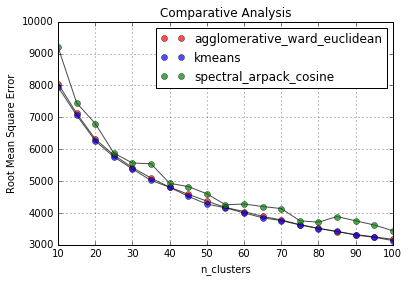

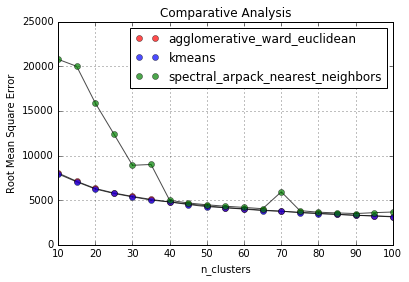

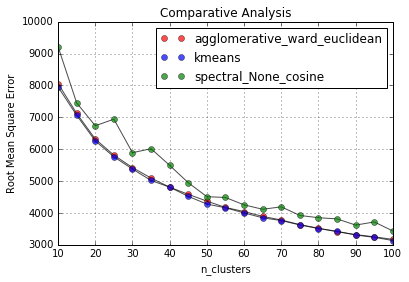

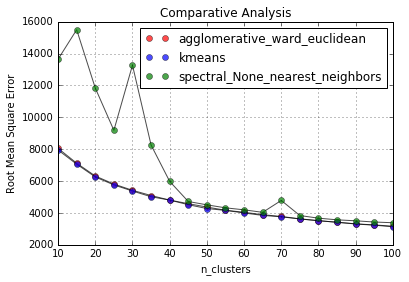

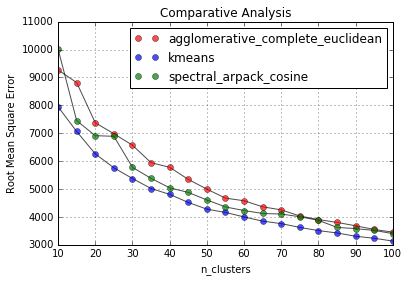

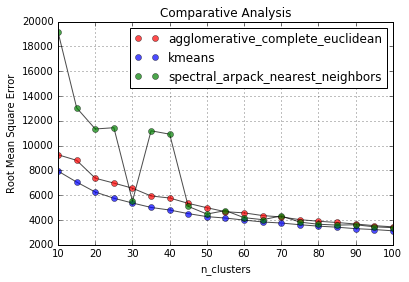

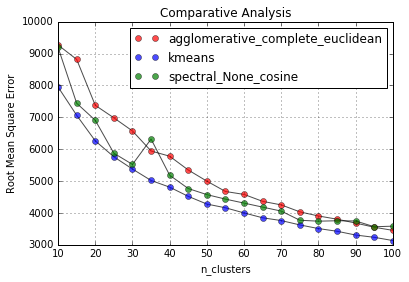

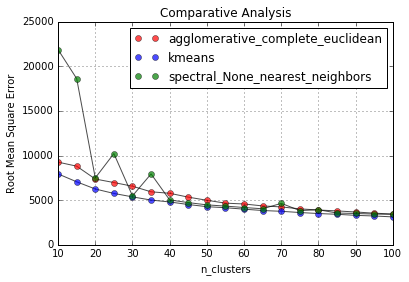

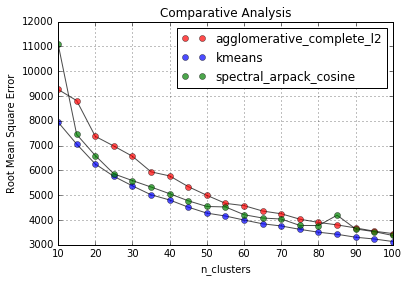

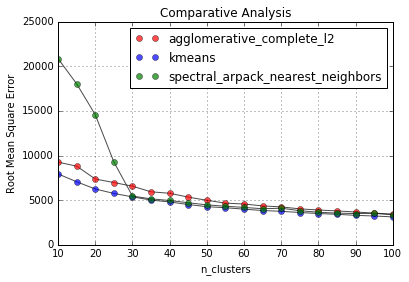

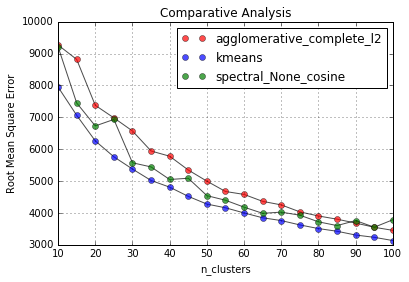

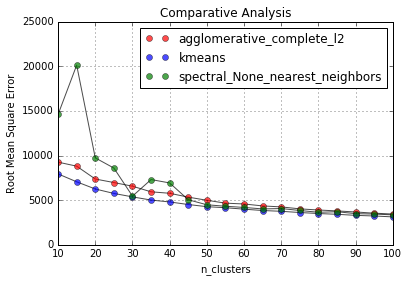

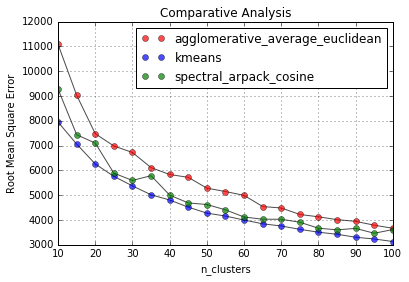

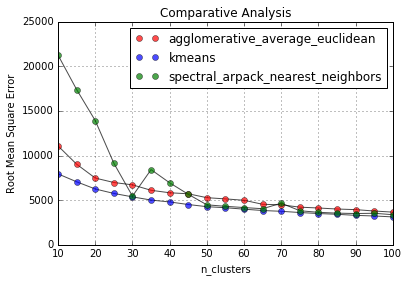

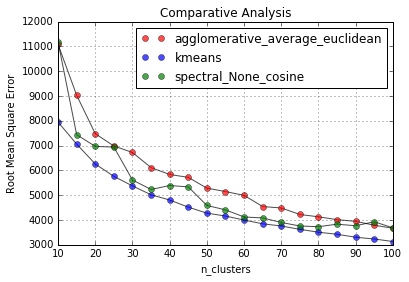

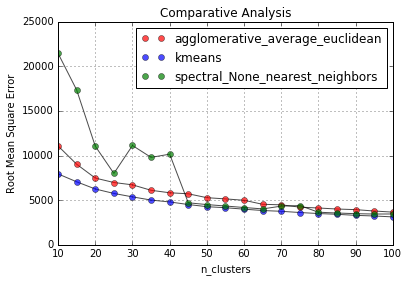

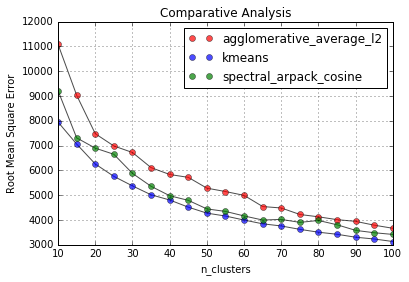

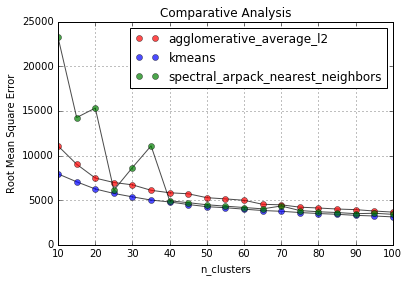

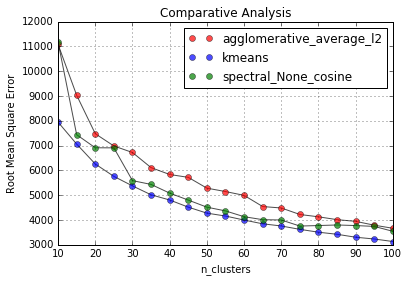

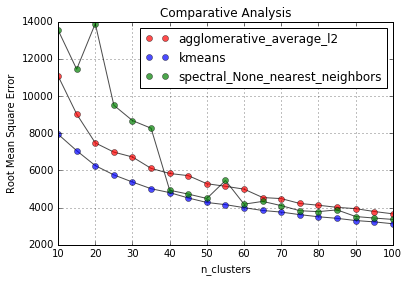

In [201]:
comparative_analysis(matrix)